In [1]:
%pip install openpyxl networkx matplotlib

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [123]:
# Load the Excel file
input_file = "Startup Investor Data.xlsx"  # Replace with your file name
output_file = "transformed_file.xlsx"  # Name of the output file
sheet_startup_names = "Startup Names"  # Replace with the sheet name containing your data
sheet_startup_data = "Startup Data"  # Replace with the sheet name containing your data


# Define the group size (number of rows to transform into columns)
group_size = 17 

# Define the columns
columns = {
	"Company Name": str,
	"Last Known Valuation": float,
	"No. of Active Investors": int,
	"Active Investors": str,
	"Competitors": str,
	"HQ Location": str,
	"Keywords": str,
	"Year Founded": int,
	"First Financing Date": str,
	"First Financing Deal Class": str,
	"First Financing Deal Type": str,
	"First Financing Deal Type 2": str,
	"Last Financing Date": str,
	"Last Financing Deal Class": str,
	"Last Financing Deal Type": str,
	"Last Financing Deal Type 2": str,
	"Primary Industry Code": str,
	"Primary Industry Sector": str
}


In [124]:
# Read the data into a DataFrame
df_startup_names = pd.read_excel(input_file, sheet_name=sheet_startup_names, header=None)
df_startup_data = pd.read_excel(input_file, sheet_name=sheet_startup_data, header=None) 

# Create a new DataFrame with reshaped data
reshaped_df_startup_names = df_startup_names.iloc[0::2].reset_index(drop=True)
reshaped_startup_data = pd.DataFrame(df_startup_data.values.reshape((-1, group_size)))

result_df = pd.concat([reshaped_df_startup_names, reshaped_startup_data], axis=1)
result_df.columns = columns.keys()
result_df = result_df.astype(columns, errors="ignore")
result_df = result_df.fillna("")
print(result_df.head())

# Save the transformed DataFrame back to Excel
result_df.to_excel(output_file, index=False, sheet_name="Transformed")

print(f"Data successfully transformed and saved to {output_file}")


  Company Name  Last Known Valuation  No. of Active Investors  \
0       OpenAI             118726.96                       99   
1       Stripe              53456.95                      150   
2   Databricks              48940.92                      113   
3          xAI              39497.22                       83   
4      Revolut              35065.96                       90   

                                    Active Investors  \
0  A.Capital Ventures, Access Ventures (New York)...   
1  1435 Capital, 500 Global, Aaron Levie, AB Priv...   
2  2B Global Capital, 535West, A&B Equity Holding...   
3  369 Growth Partners, Abstract Ventures, Access...   
4  10X Group, 2B Global Capital, Adjacent (New Yo...   

                                         Competitors              HQ Location  \
0  Hugging Face, Haiper, Mistral AI_, Imagga, Lan...        San Francisco, CA   
1  Mastercard OB Services Europe, First American ...  South San Francisco, CA   
2  Streamlio, KloudFuse, Good

In [125]:
def isCompetitor(G, node1, node2):
    competitors1 = set(G.nodes[node1]["Competitors"].split(", "))
    competitors2 = set(G.nodes[node2]["Competitors"].split(", "))
    return node1 in competitors2 and node2 in competitors1

def isInvestorCommon(G, node1, node2):
    investors1 = set(G.nodes[node1]["Active Investors"].split(", "))
    investors2 = set(G.nodes[node2]["Active Investors"].split(", "))
    return bool(investors1 & investors2)

def isInvestorCommonWithCompetitor(G, node1, node2):
    return isInvestorCommon(G, node1, node2) and isCompetitor(G, node1, node2)

In [126]:

# Create a network graph from the data
G = nx.Graph()

# Add nodes with attributes
for _, row in result_df.iterrows():
    company_name = row["Company Name"]
    attributes = row.drop("Company Name").to_dict()  # Convert other columns to a dictionary
    # Convert all attributes to strings to ensure valid types for GEXF export, except for integers
    # attributes = {k: str(v) if not isinstance(v, int) else v for k, v in attributes.items()}
    G.add_node(company_name, **attributes)

# Add edges based on shared active investors
for node1, node2 in combinations(G.nodes, 2):  # All pairs of nodes
    if isCompetitor(G, node1, node2):
        G.add_edge(node1, node2)



In [132]:
from collections import Counter

# Split the comma-separated strings and flatten the list
competitors_list = result_df['Competitors'].str.split(', ').explode()

# Count the frequency of each competitor
competitor_frequency = Counter(competitors_list)

# Convert the Counter object to a DataFrame for better readability
competitor_frequency_df = pd.DataFrame.from_dict(competitor_frequency, orient='index', columns=['Frequency']).reset_index()
competitor_frequency_df = competitor_frequency_df.rename(columns={'index': 'Competitor'})

# sort dataframe by frequency in descending order
competitor_frequency_df = competitor_frequency_df.sort_values(by='Frequency', ascending=False)

print(competitor_frequency_df.head(20))

                 Competitor  Frequency
237              Salesforce         53
586                     nan         51
76                 Firebase         45
273        Tableau Software         41
295           SAS Institute         41
261               KloudFuse         41
284          TIBCO Software         39
300         Urchin Software         39
281                 Alteryx         35
338                     SAP         34
312                  Talend         33
402                  Stripe         32
88                   Looker         30
267                Datameer         30
195         PayPal Holdings         29
264       Qlik Technologies         28
290            BMC Software         27
316  Infor Global Solutions         27
45                  Sisense         26
263                   Birst         25


Graph Edges:
185
('OpenAI', 'xAI', {})
('OpenAI', 'Mistral AI_', {})
('OpenAI', 'Cohere', {})
('OpenAI', 'Inflection AI', {})
('OpenAI', 'Runway (Multimedia and Design Software)', {})
('Stripe', 'Checkout.com', {})
('Stripe', 'Ripple', {})
('Stripe', 'Brex', {})
('Stripe', 'Tipalti', {})
('Stripe', 'ChargeBee', {})
('Databricks', 'DataRobot', {})
('Databricks', 'Dataiku', {})
('Databricks', 'Redis', {})
('Databricks', 'DataStax', {})
('Databricks', 'Astronomer', {})
('Databricks', 'Avathon', {})
('Revolut', 'Monzo', {})
('Revolut', 'Nium', {})
('Revolut', 'Stash Financial', {})
('Epic Games', 'Improbable', {})
('Epic Games', 'Sorare', {})
('Canva', 'Figma', {})
('Miro', 'Figma', {})
('Miro', 'Clickup', {})
('Miro', 'Lucid Software', {})
('Miro', 'MURAL', {})
('Yuanfudao', 'Zuoyebang', {})
('Scale AI', 'Hive (Business/ Pro ductivity Software)', {})
('Ripple', 'Blockchain.com', {})
('Ripple', 'Blockstream', {})
('Ripple', 'BitGo', {})
('Rippling', 'Deel', {})
('Rippling', 'Gusto', {})
('

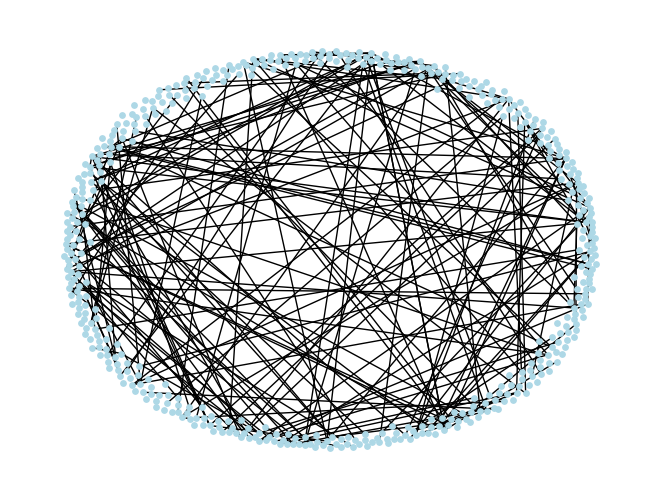

In [127]:
node_labels = {node: node for node in G.nodes()}

# Print graph edges with shared active investors
print("Graph Edges:")
print(len(G.edges()))
for edge in G.edges(data=True):
    print(edge)

pos = nx.spring_layout(G, k=5, iterations=100)  # Layout for visualization
nx.draw(G, pos, with_labels=False, labels=node_labels, node_color="lightblue", node_size=15)
# plt.show()

In [128]:
nx.write_gexf(G, "startup_investor_data.gexf")  # Save the graph to a file